# Interatomic potentials

In general interatomic potentials can be written as a sum of functional terms depending on the positions of the atoms in a structure. Then the energy $U$ of the system is

$U = \sum_{i=1}^N U_1(\vec{r_i}) + \sum_{i,j=1}^N U_2(\vec{r_i}, \vec{r_j}) + \sum_{i,j,k=1}^N U_2(\vec{r_i}, \vec{r_j}, \vec{r_k}) +...$

The one body term only matter when the system is within an external field. Most classic interatomic potentials don't use 4th and higher order body terms, pair potentials only use the 2 body term. As a general rule potentials that include higher order body terms can be more accurate but are slower.

There are many different forms for $U_i$, which cover a wide range of different run time and accuracy necessities.

Simple pair potentials (f.e Lennard-Jones, Morse, Buckingham) only contain very few parameters, typically less than 10. In many body potentials (f.e. EAM, MEAM, Tersoff) the typical number of parameters is 10-50 and for machine learning potentials the number of parameters can reach several thousands.

# Fitting

In the fit process the parameters of the chosen functions for $U_i$ are optimized. For this purpose an objective or cost function is defined and minimized. In general the objective function is defined as

$\chi^2 = \sum_i w_i r_i$

where $w_i$ is a weight and $r_i$ is a residual that describes the difference to target values. This residual can be defined in different ways, so it is not possible to simply compare the residual for different fitting processes or codes. A more in depth explanation and some examples can be found on https://atomicrex.org/overview.html#objective-function.

The minimization can be done with local or global optimization algorithms.
Generally local optimization algorithms should all be able to find the local minimum coming from some initial parameter set, so the "best" local algorithm is the one finding the minimum in the shortest time. Typically used local algorithms are f.e. (L)BFGS or Nelder-Mead.
Examples for global algorithms are evolutionary algorithms or simulated annealing. For most problems it is impossible to tell a priori which global algorithm will give the best results, so using global algorithms typically involves testing many of them.

# EAM potentials

EAM potentials are pair functionals. 
In a generalised form they are equal to Finnis-Sinclair, effective medium theory or glue potentials. Their total energy can be written as

$E = \frac{1}{2}\sum_{ij}V(r_{ij}) + \sum_i F(\rho_i)$

with

$\rho_i = \sum_j \rho(r_{ij})$

The original functions for V, $\rho$ and F were derived from different theories, but they can be chosen freely.

# Fitting code

Fitting is done using the pyiron interface to the atomicrex code https://atomicrex.org. It can be used to fit different types of classic interatomic potentials:
- pair potentials
- EAM
- MEAM
- Tersoff
- ABOP
- ADP (in development)

It allows to fit different properties (energies, forces, lattice constants, elastic properties, etc.) and implements the LBFGS minimizer. Additionally it offers an interface to the nlopt library which implements several global and local optimization algorithms and the ability to apply arbitrary constraints to parameters.

In [1]:
from pyiron import Project, ase_to_pyiron
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
pr = Project(".")

### Get the training data
Load a job that contains structures with energies and forces from DFT

In [3]:
tc = pr.create.job.TrainingContainer("TrainData", delete_existing_job=True)
df = pd.read_pickle("Al_3PreFinal.pckl.gz")
for r in df.itertuples():
    s = ase_to_pyiron(r.ase_atoms)
    if r.energy_corrected > 0:
        continue
    vol = s.get_volume()
    natoms = len(s)
    if vol/natoms > 120:
        continue
    tc.add_structure(structure=s, energy=r.energy_corrected, forces=r.forces, name=f"ID{r.Index}")
tc.run()

The job TrainData was saved and received the ID: 738901


### Have a look at the training data

,V,E,space_group,crystal_system
0,16.484415,-3.482751,225,cubic
1,14.835973,-3.433909,225,cubic
2,15.165661,-3.452735,225,cubic
3,15.495350,-3.466526,225,cubic
4,15.825038,-3.475815,225,cubic
...,...,...,...,...
303,28.793489,-2.746083,1,triclinic
304,29.358067,-2.708848,1,triclinic
305,29.922645,-2.672118,1,triclinic
306,30.487223,-2.635916,1,triclinic


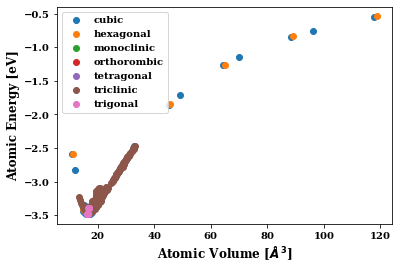

In [4]:
tc.plot.energy_volume(crystal_systems=True)

,a,b,c,alpha,beta,gamma,V,N
0,4.039967,4.039967,4.039967,90.000000,90.000000,90.000000,65.937658,4
1,3.900545,3.900545,3.900545,90.000000,90.000000,90.000000,59.343892,4
2,3.929227,3.929227,3.929227,90.000000,90.000000,90.000000,60.662645,4
3,3.957496,3.957496,3.957496,90.000000,90.000000,90.000000,61.981399,4
4,3.985366,3.985366,3.985366,90.000000,90.000000,90.000000,63.300152,4
...,...,...,...,...,...,...,...,...
303,7.008729,7.232998,10.690023,121.764941,89.204727,90.106498,460.695818,16
304,7.054241,7.279967,10.759441,121.764941,89.204727,90.106498,469.729069,16
305,7.099174,7.326338,10.827974,121.764941,89.204727,90.106498,478.762321,16
306,7.143545,7.372128,10.895651,121.764941,89.204727,90.106498,487.795572,16


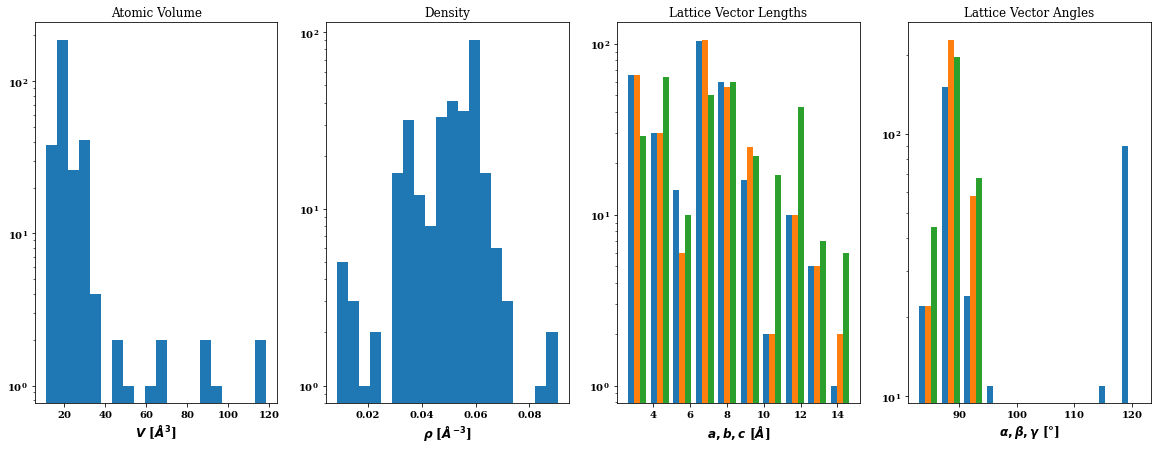

In [5]:
plt.figure(figsize=(20,7))
tc.plot.cell()

### Create an atomicrex job

In [6]:
job = pr.create.job.Atomicrex("FitAl", delete_existing_job=True)

### Training Data
Set the training data. This can also be done structure by structure to set other fit properties and weights, but here we simply load the TrainingContainer

In [7]:
job.structures.add_training_data(tc)

Set the potential type. In this case an EAM potential

In [8]:
job.potential = job.factories.potentials.eam_potential()

### Functions
Reminder: $E = \sum_{ij}V(r_{ij}) + \sum_i F(\rho_i)$ with $\rho_i = \sum_j \rho(r_{ij})$

It is necessary to define a pair potential, an electronic density function and an embedding function.
For all of those it is possible to choose between different functional forms.
Classic pair potentials are physically motivated and have a very limited number of paramaters that can often be derived from an experimentally measurable quantity.
Splines or polynomials offer more flexibility, but can lead to unphysical oscillations or overfitting. Compared with the machine learning potentials shown later the number of parameters is very low no matter which functions you choose.

In this case a generalized morse function is used for the pair interaction. It has the form

$(\frac{D_0}{S-1}exp(-\beta \sqrt{2S}(r-r_0))-\frac{D_0S}{S-1}exp(-\beta\sqrt{2/S}(r-r_0)))+\delta $

The parameters in the morse potential can be derived from phyiscal quantities, here they are just educated guesses. For example $r_0$ is the equilibrium distance of a dimer. The nearest neighbor distance in fcc Cu is about 2.8 $\mathring A$ so it is taken as initial value.
In the case of analytic functions the initial parameter choices should not matter too much, since the functional form is constrained.

The electronic density will be a cubic spline. The embedding function will be $-A*sqrt(\rho)+B*rho$, which can be defined as a user function.

The pair function and the electron denity and their first derivatives are required to smoothly approach 0 at the cutoff distance $r_{c}$
For this purpose the pair function is screened by multiplying with the function:

$\Psi(\frac{r-rc}{h})$ where $\Psi(x) = \frac{x^4}{1+x^4}$ if $x<0$ else $\Psi(x)=0$

For the spline it is necessary to set a node point with y value 0 at the cutoff 

In [9]:
morseB = job.factories.functions.morse_B("V", D0=0.15, r0=3.05, beta=1.1, S=4.1, delta=-0.01)
morseB.screening = job.factories.functions.x_pow_n_cutoff(identifier="V_screen", cutoff=7.6)
morseB.parameters.D0.min_val = 0.05
morseB.parameters.D0.max_val = 1.55

morseB.parameters.r0.min_val = 2.6
morseB.parameters.r0.max_val = 3.1

morseB.parameters.S.min_val = 1.5
morseB.parameters.S.max_val = 4.5
morseB.parameters.delta.max_val = 0.005

It is also possible to plot most of the functions. This can help to judge if the initial parameters are reasonable

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:xlabel='r [$\\AA$]', ylabel='func(r)'>)

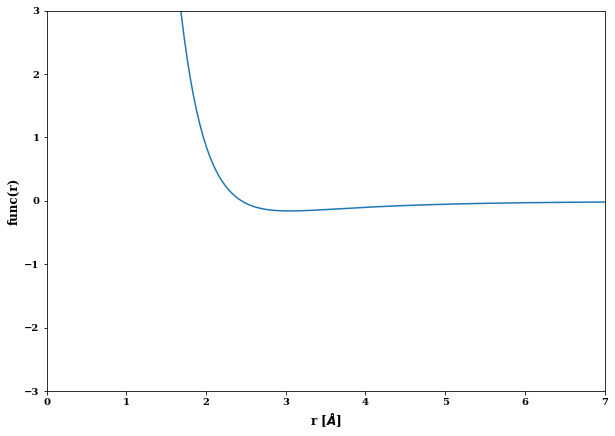

In [10]:
morseB.plot()

In [11]:
rho = job.factories.functions.spline(identifier="rho_AlAl", cutoff=7.6, derivative_left=-0.2, derivative_right=0)
## the spline requires node points and initial values
init_func = lambda r: np.exp(-r)
nodes = np.array([1.0, 2.2, 2.7, 3.2, 4.0, 5.0])
init_vals = init_func(nodes)
rho.parameters.create_from_arrays(x=nodes, y=init_vals, min_vals=np.zeros(len(nodes)), max_vals=np.ones(len(nodes)))
# set node point at cutoff
rho.parameters.add_node(x=7.6, start_val=0, enabled=False)
rho.derivative_left.max_val = 0.0

In [12]:
# User function for embedding term
F = job.factories.functions.user_function(identifier="F", input_variable="r")
F.expression = "-A*sqrt(r)+B*r"
F.derivative = "-A/(2*sqrt(r))+B"
F.parameters.add_parameter("A", start_val=3.3, min_val=0.0)
F.parameters.add_parameter("B", start_val=1.8, min_val=0.0)

Assign functions

In [13]:
job.potential.pair_interactions[morseB.identifier] = morseB
job.potential.electron_densities[rho.identifier] = rho
job.potential.embedding_energies[F.identifier] = F

Set a fit algorithm

In [14]:
job.input.fit_algorithm = job.factories.algorithms.ar_lbfgs(max_iter=10000)

In [15]:
job.run()

The job FitAl was saved and received the ID: 738902


Have a look at some of the outputs

3366.772277399672

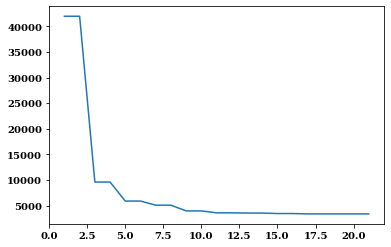

In [16]:
plt.plot(job.output.iterations, job.output.residual)
job.output.residual[-1]

In [17]:
job.potential

EAMPotential({'pair_interactions': DataContainer({'V': MorseB({'species': ['*', '*'], 'parameters': FunctionParameterList({'D0': FunctionParameter({'param': 'D0', 'start_val': 0.15, 'enabled': True, 'reset': False, 'min_val': 0.05, 'max_val': 1.55, 'tag': None, 'fitable': True, 'final_value': 0.1530946632052217}), 'r0': FunctionParameter({'param': 'r0', 'start_val': 3.05, 'enabled': True, 'reset': False, 'min_val': 2.6, 'max_val': 3.1, 'tag': None, 'fitable': True, 'final_value': 3.051226104734049}), 'beta': FunctionParameter({'param': 'beta', 'start_val': 1.1, 'enabled': True, 'reset': False, 'min_val': None, 'max_val': None, 'tag': None, 'fitable': True, 'final_value': 1.354779328092613}), 'S': FunctionParameter({'param': 'S', 'start_val': 4.1, 'enabled': True, 'reset': False, 'min_val': 1.5, 'max_val': 4.5, 'tag': None, 'fitable': True, 'final_value': 4.099994790262965}), 'delta': FunctionParameter({'param': 'delta', 'start_val': -0.01, 'enabled': True, 'reset': False, 'min_val': None, 'max_val': 0.005, 'tag': None, 'fitable': True, 'final_value': -0.01532934405060739})}), 'is_screening_function': False, 'identifier': 'V', 'screening': XpowNCutoff({'species': ['*', '*'], 'parameters': FunctionParameterList({'cutoff': FunctionParameter({'param': 'cutoff', 'start_val': 7.6, 'enabled': False, 'reset': False, 'min_val': None, 'max_val': None, 'tag': None, 'fitable': False, 'final_value': None}), 'h': FunctionParameter({'param': 'h', 'start_val': 1, 'enabled': False, 'reset': False, 'min_val': None, 'max_val': None, 'tag': None, 'fitable': True, 'final_value': None}), 'N': FunctionParameter({'param': 'N', 'start_val': 4, 'enabled': False, 'reset': False, 'min_val': None, 'max_val': None, 'tag': None, 'fitable': True, 'final_value': None})}), 'is_screening_function': True, 'identifier': 'V_screen'})})}), 'electron_densities': DataContainer({'rho_AlAl': Spline({'identifier': 'rho_AlAl', 'cutoff': 7.6, 'derivative_left': FunctionParameter({'param': 'derivative-left', 'start_val': -0.2, 'enabled': True, 'reset': False, 'min_val': None, 'max_val': 0.0, 'tag': None, 'fitable': True, 'final_value': -0.2003639909380159}), 'derivative_right': FunctionParameter({'param': 'derivative-right', 'start_val': 0, 'enabled': False, 'reset': False, 'min_val': None, 'max_val': None, 'tag': None, 'fitable': True, 'final_value': None}), 'species': ['*', '*'], 'parameters': NodeList({'node_1': Node({'param': 'node', 'start_val': 0.36787944117144233, 'enabled': True, 'reset': False, 'min_val': 0.0, 'max_val': 1.0, 'tag': None, 'fitable': True, 'final_value': 0.3678099451630189, 'x': 1.0}), 'node_2.2': Node({'param': 'node', 'start_val': 0.11080315836233387, 'enabled': True, 'reset': False, 'min_val': 0.0, 'max_val': 1.0, 'tag': None, 'fitable': True, 'final_value': 0.1116747345072877, 'x': 2.2}), 'node_2.7': Node({'param': 'node', 'start_val': 0.06720551273974976, 'enabled': True, 'reset': False, 'min_val': 0.0, 'max_val': 1.0, 'tag': None, 'fitable': True, 'final_value': 0.07145424033657911, 'x': 2.7}), 'node_3.2': Node({'param': 'node', 'start_val': 0.04076220397836621, 'enabled': True, 'reset': False, 'min_val': 0.0, 'max_val': 1.0, 'tag': None, 'fitable': True, 'final_value': 0.04425295799860187, 'x': 3.2}), 'node_4': Node({'param': 'node', 'start_val': 0.01831563888873418, 'enabled': True, 'reset': False, 'min_val': 0.0, 'max_val': 1.0, 'tag': None, 'fitable': True, 'final_value': 0.01922526131909083, 'x': 4.0}), 'node_5': Node({'param': 'node', 'start_val': 0.006737946999085467, 'enabled': True, 'reset': False, 'min_val': 0.0, 'max_val': 1.0, 'tag': None, 'fitable': True, 'final_value': 0.006425127502193282, 'x': 5.0}), 'node_7.6': Node({'param': 'node', 'start_val': 0, 'enabled': False, 'reset': False, 'min_val': None, 'max_val': None, 'tag': None, 'fitable': True, 'final_value': None, 'x': 7.6})})})}), 'embedding_energies': DataContainer({'F': UserFunction({'input_variable': 'r', 'identifier': 'F', 'species': ['*', '*'], 'parameters': FunctionP

(<Figure size 576x1296 with 3 Axes>,
 array([[<AxesSubplot:title={'center':'Al F'}, xlabel='$\\rho $ [a.u.]'>],
        [<AxesSubplot:title={'center':'Al rho_AlAl'}, xlabel='r [$\\AA$]'>],
        [<AxesSubplot:title={'center':'Al V_AlAl'}, xlabel='r [$\\AA$]'>]],
       dtype=object))

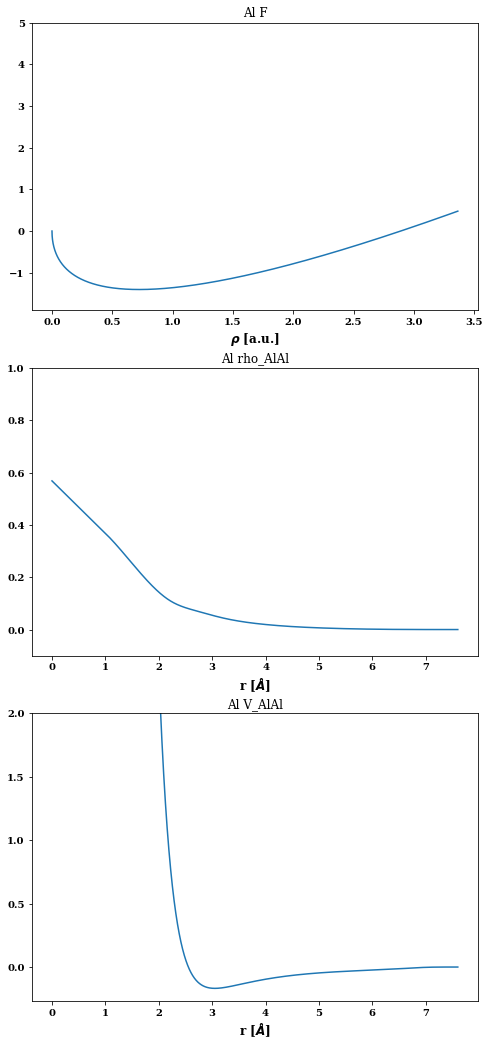

In [18]:
job.plot_final_potential()

Acces the plotting interface common to the different fitting codes usable via pyiron

In [19]:
plots = job.plot

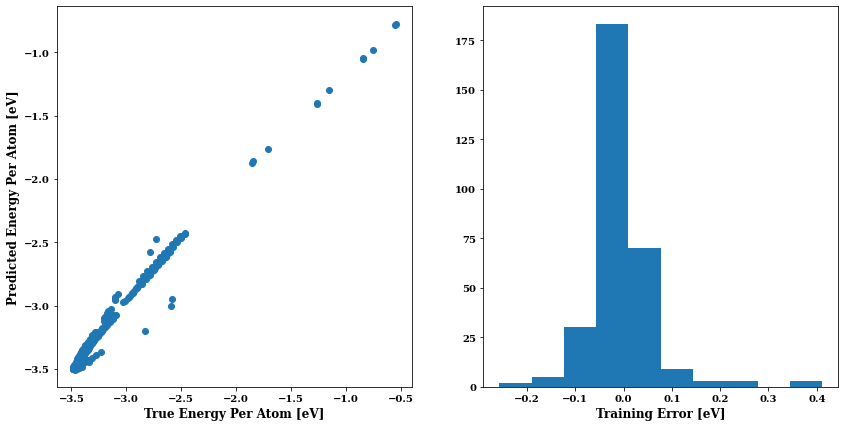

In [20]:
plt.figure(figsize=(14,7)) # Increase the size a bit
plots.energy_scatter_histogram()

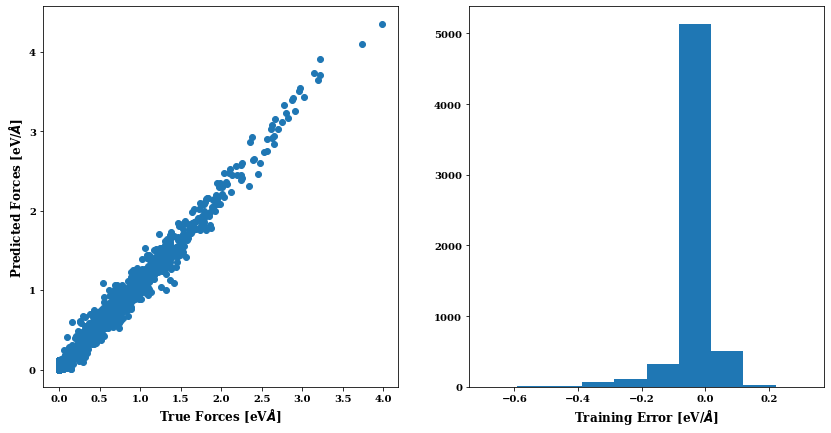

In [21]:
plt.figure(figsize=(14,7))
plots.force_scatter_histogram()

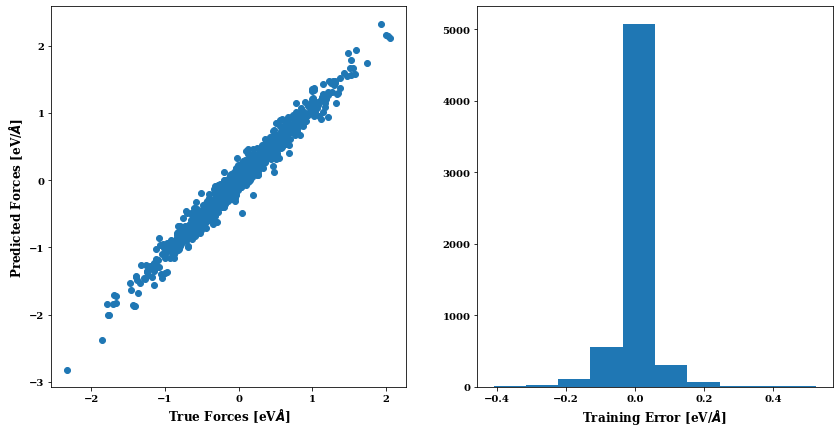

In [22]:
plt.figure(figsize=(14,7))
plots.force_scatter_histogram(axis=0)

### Short Test

In [23]:
lmp = pr.create.job.Lammps("Al", delete_existing_job=True)
lmp.structure = pr.create.structure.ase.bulk("Al", cubic=True)
lmp.potential = job.lammps_potential
lmp.calc_minimize(pressure=0)
lmp.run()

The job Al was saved and received the ID: 738903


In [24]:
lmp.get_structure()

Al: [0. 0. 0.]
Al: [0.         1.98553722 1.98553722]
Al: [1.98553722e+00 1.21579090e-16 1.98553722e+00]
Al: [1.98553722e+00 1.98553722e+00 2.43158180e-16]
pbc: [ True  True  True]
cell: 
Cell([[3.9710744457956384, 2.431581804609739e-16, 2.431581804609739e-16], [0.0, 3.9710744457956384, 2.431581804609739e-16], [0.0, 0.0, 3.9710744457956384]])

In [25]:
ref = pr.create.job.Lammps("AlRef")
ref.structure = lmp.get_structure()
ref.potential = job.lammps_potential

murn = pr.create.job.Murnaghan("AlMurn", delete_existing_job=True)
murn.ref_job = ref
murn.run()

The job AlMurn was saved and received the ID: 738904
The job AlMurn_0_9 was saved and received the ID: 738905
The job AlMurn_0_92 was saved and received the ID: 738906
The job AlMurn_0_94 was saved and received the ID: 738907
The job AlMurn_0_96 was saved and received the ID: 738908
The job AlMurn_0_98 was saved and received the ID: 738909
The job AlMurn_1_0 was saved and received the ID: 738910
The job AlMurn_1_02 was saved and received the ID: 738911
The job AlMurn_1_04 was saved and received the ID: 738912
The job AlMurn_1_06 was saved and received the ID: 738913
The job AlMurn_1_08 was saved and received the ID: 738915
The job AlMurn_1_1 was saved and received the ID: 738916


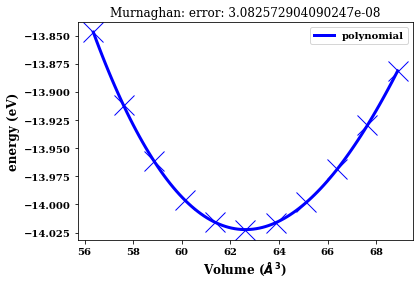

<AxesSubplot:title={'center':'Murnaghan: error: 3.082572904090247e-08'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [26]:
murn.plot()

In [27]:
murn.fit_polynomial()

{'poly_fit': array([-6.99807253e-05,  1.71831609e-02, -1.32879944e+00,  1.89910998e+01]),
 'fit_type': 'polynomial',
 'fit_order': 3,
 'volume_eq': 62.622371605280996,
 'energy_eq': -14.022341476671993,
 'bulkmodul_eq': 80.98975711851953,
 'b_prime_eq': 2.257384373924286,
 'least_square_error': 3.082572904090247e-08}

### Improving the potential:
- try with different starting parameters / global optimization
- change weights of structures and fit properties
- change functions used